In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ember-2017-v2-features/ember-2017-v2f-fastai-tl-0-auroc.ipynb
/kaggle/input/ember-2017-v2-features/train_ember_2017_v2_features.parquet
/kaggle/input/ember-2017-v2-features/test_ember_2017_v2_features.parquet


In [2]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, RocCurveDisplay

from fastai.tabular.all import *

In [3]:
df_train = pd.read_parquet('/kaggle/input/ember-2017-v2-features/train_ember_2017_v2_features.parquet')

df_test = pd.read_parquet('/kaggle/input/ember-2017-v2-features/test_ember_2017_v2_features.parquet')

In [4]:
df_train = df_train[df_train['Label'].isin([0,1])]

In [5]:
train_samples = df_train.shape[0]

test_samples = df_test.shape[0]

train_samples, test_samples

(599785, 199980)

In [6]:
target = 'Label'

In [7]:
df = pd.concat(objs=[df_train, df_test], axis=0, copy=True, sort=False, ignore_index=True)

df.shape

(799765, 2382)

In [8]:
import gc

del [[df_train, df_test]]

gc.collect()

df_train = pd.DataFrame()

df_test = pd.DataFrame()

In [9]:
conts, cats = cont_cat_split(df, dep_var=target)

len(conts), len(cats)

(2381, 0)

In [10]:
df = TabularPandas(

    df=df, 

    procs=[Normalize],

    cat_names=cats,

    cont_names=conts,

    y_block=CategoryBlock,

    y_names=target,

    splits = IndexSplitter(valid_idx=range(train_samples, train_samples+test_samples))(range_of(df)),

    reduce_memory=True,

)

In [11]:
df

              F1        F2        F3        F4        F5        F6        F7  \
0      -1.257588 -0.687801 -0.482446 -0.249102 -0.354949 -0.049485 -0.148315   
1      -0.944049  0.141246  0.403114  0.467618  0.058928  0.628935  0.379709   
2      -0.333276  1.595154 -0.262116 -0.032476 -0.025913 -0.102497  0.120361   
3      -1.288671 -0.701891 -0.482188 -0.259549 -0.352604 -0.028828 -0.145364   
4      -1.226432 -0.604248 -0.408228 -0.241456 -0.336437  0.001691 -0.153813   
...          ...       ...       ...       ...       ...       ...       ...   
799760  0.672422  1.088602  1.865545  0.937794  0.510004  0.576001  0.767541   
799761  2.397116 -0.645876 -0.423803 -0.445602 -0.324192 -0.645569 -0.583187   
799762 -0.977334 -0.513192 -0.356195  0.074857 -0.112065 -0.331447 -0.273750   
799763 -0.954319 -0.671922 -0.598519 -0.371219 -0.334086 -0.260170 -0.332661   
799764  1.191468  1.543273  0.540032 -0.027944  0.258468  0.145418  0.550918   

              F8        F9       F10  .

In [12]:
len(df.train), len(df.valid)

(599785, 199980)

In [13]:
dls = df.dataloaders(bs=64)

## Fast.ai TabularLearner results

In [14]:
roc_auc_binary = RocAucBinary()

tl = tabular_learner(dls, metrics=[roc_auc_binary])

In [15]:
cbs = [

    TrackerCallback(monitor='valid_loss', comp=None, min_delta=0.0, reset_on_fit=True),

    EarlyStoppingCallback(monitor='valid_loss', comp=None, min_delta=0.0, patience=1, reset_on_fit=True)

]

tl.fit_one_cycle(10, cbs=cbs) # learning rate scheduling: docs.fast.ai/callback.schedule.html#learner.fit_one_cycle

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.046338,26.371597,0.986745,00:53
1,0.038666,80.493706,0.987476,00:54


No improvement since epoch 0: early stopping


In [16]:
preds_train, ground_truth_train = tl.get_preds(ds_idx=0, dl=None)

In [17]:
preds_train

tensor([[9.4054e-01, 5.9464e-02],
        [9.3700e-01, 6.2996e-02],
        [9.9999e-01, 6.4584e-06],
        ...,
        [3.2463e-06, 1.0000e+00],
        [1.2990e-04, 9.9987e-01],
        [5.4641e-04, 9.9945e-01]])

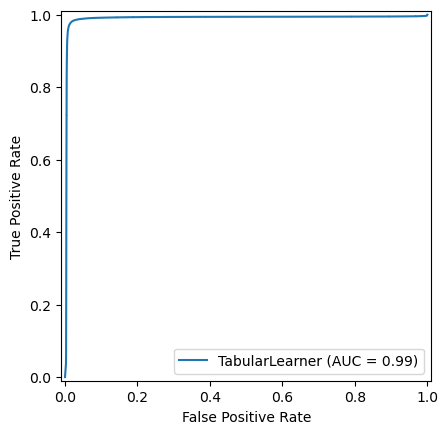

In [18]:
fpr, tpr, thresholds = roc_curve(to_np(ground_truth_train), to_np(preds_train[:,1]))

J = tpr - fpr

ix = np.argmax(J)

best_thresh = thresholds[ix]

roc_auc = auc(fpr, tpr)



display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='TabularLearner')

display.plot()

In [19]:
# Test set predictions

preds_test, ground_truth_test = tl.get_preds(ds_idx=1, dl=None) # we want the validation (test) set hence ds_idx=1

In [20]:
# transform tensor to numpy array

preds_test = to_np(preds_test[:,1]) # keep only prediction values for the positive class

ground_truth_test = to_np(ground_truth_test)



preds_test_binary = (preds_test >= best_thresh).astype(int)



print("Test predictions shape:", preds_test_binary.shape)

print("Best threshold:", best_thresh)

Test predictions shape: (199980,)
Best threshold: 0.49837288


In [21]:
print("The final tabular learner results")

print("ROC-AUC:", round(roc_auc_score(y_true=ground_truth_test, y_score=preds_test), 4))  # Use probability for ROC-AUC

print("Precision:", round(precision_score(y_true=ground_truth_test, y_pred=preds_test_binary), 4))

print("Recall:", round(recall_score(y_true=ground_truth_test, y_pred=preds_test_binary), 4))

print("F1:", round(f1_score(y_true=ground_truth_test, y_pred=preds_test_binary), 4))

The final tabular learner results
ROC-AUC: 0.9875
Precision: 0.9817
Recall: 0.9761
F1: 0.9789
